# 🎶 Music Generation with Transformers

In this notebook, we'll walk through the steps required to train your own Transformer model to generate music in the style of the Bach cello suites

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the Model](#build)
3. [Train the Model](#train)
4. [Generate images](#generate)

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-colorblind")

import os
import glob
import json
from pprint import pprint
import random
import re
import time

import string
from IPython.display import display, HTML

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
from tensorflow.keras.utils import plot_model
import keras_nlp

import music21

import absl.logging

absl.logging.set_verbosity(absl.logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from utils.music import parse_midi_files, create_lookup_tables, load_parsed_files, get_midi_note

2022-11-04 15:04:26.697105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 15:04:26.697153: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 0. Parameters <a name="parameters"></a>

In [2]:
PARSE_MIDI_FILES = False
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 5000
BATCH_SIZE = 256

GENERATE_LEN = 50

## 1. Prepare the Data

In [3]:
# Load the data
file_list = glob.glob("/app/data/bach-cello/*.mid")
print(f"Found {len(file_list)} midi files")

Found 36 midi files


In [4]:
parser = music21.converter

In [5]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(file_list, parser, SEQ_LEN + 1)
else:
    notes, durations = load_parsed_files()

In [6]:
example_notes = notes[0]
example_durations = durations[0]

print("{:10} {:10}".format("pitch", "duration"))
for n, d in zip(example_notes.split()[:11], example_durations.split()[:11]):
    print(f"{n:10} {d:10}")

pitch      duration  
START      0.0       
G:major    0.0       
4/4TS      0.0       
G2         0.25      
D3         0.25      
B3         0.25      
A3         0.25      
B3         0.25      
D3         0.25      
B3         0.25      
D3         0.25      


## 2. Tokenize the data <a name="tokenize"></a>

In [7]:
def create_dataset(elements):
    ds = tf.data.Dataset.from_tensor_slices(elements).batch(BATCH_SIZE, drop_remainder=True).shuffle(1000)
    vectorize_layer = keras.layers.TextVectorization(standardize=None, output_mode="int")
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(durations)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

2022-11-04 15:04:30.397397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-04 15:04:30.397683: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-04 15:04:30.397730: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d738adb06866): /proc/driver/nvidia/version does not exist
2022-11-04 15:04:30.398239: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("pitch token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(example_tokenised_notes.numpy()[:11], example_tokenised_durations.numpy()[:11])
):
    print(f"{note_int:10}{duration_int:10}")

pitch token duration token
        37        10
        51        10
        42        10
        16         2
         4         2
         9         2
         3         2
         9         2
         4         2
         9         2
         4         2


In [196]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


## 3. Create the Training Set <a name="create"></a>

In [10]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [11]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 9,  6, 12, ...,  2,  8, 13],
       [ 6, 12,  8, ...,  8, 13, 16],
       [12,  8, 12, ..., 13, 16,  6],
       ...,
       [ 9,  6,  7, ..., 11,  3, 11],
       [ 6,  7, 23, ...,  3, 11,  6],
       [ 7, 23,  7, ..., 11,  6, 11]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[10, 19,  3, ...,  3,  3,  3],
       [19,  3,  8, ...,  3,  3,  3],
       [ 3,  8,  3, ...,  3,  3,  3],
       ...,
       [ 3,  3,  3, ...,  4,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3],
       [ 3,  3,  3, ...,  3,  3,  3]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 6, 12,  8, ...,  8, 13, 16],
       [12,  8, 12, ..., 13, 16,  6],
       [ 8, 12,  4, ..., 16,  6,  2],
       ...,
       [ 6,  7, 23, ...,  3, 11,  6],
       [ 7, 23,  7, ..., 11,  6, 11],
       [23,  7,  6, ...,  6, 11,  6]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[19,  3,  8, ...,  3,  3,  3],
       [ 3,  8,  3, ...,  3,  3, 

## 5. Create the causal attention mask function <a name="causal"></a>

In [12]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0)
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## 6. Create a Transformer Block layer <a name="transformer"></a>

In [13]:
class TransformerBlock(keras.layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, name, dropout_rate=DROPOUT_RATE):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = keras.layers.MultiHeadAttention(num_heads, key_dim, output_shape=embed_dim)
        self.dropout_1 = keras.layers.Dropout(self.dropout_rate)
        self.ln_1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = keras.layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = keras.layers.Dense(self.embed_dim)
        self.dropout_2 = keras.layers.Dropout(self.dropout_rate)
        self.ln_2 = keras.layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output, attention_scores = self.attn(
            inputs, inputs, attention_mask=causal_mask, return_attention_scores=True
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

## 7. Create the Token and Position Embedding <a name="embedder"></a>

In [14]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, embeddings_initializer="he_uniform"
        )
        self.pos_emb = keras_nlp.layers.SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

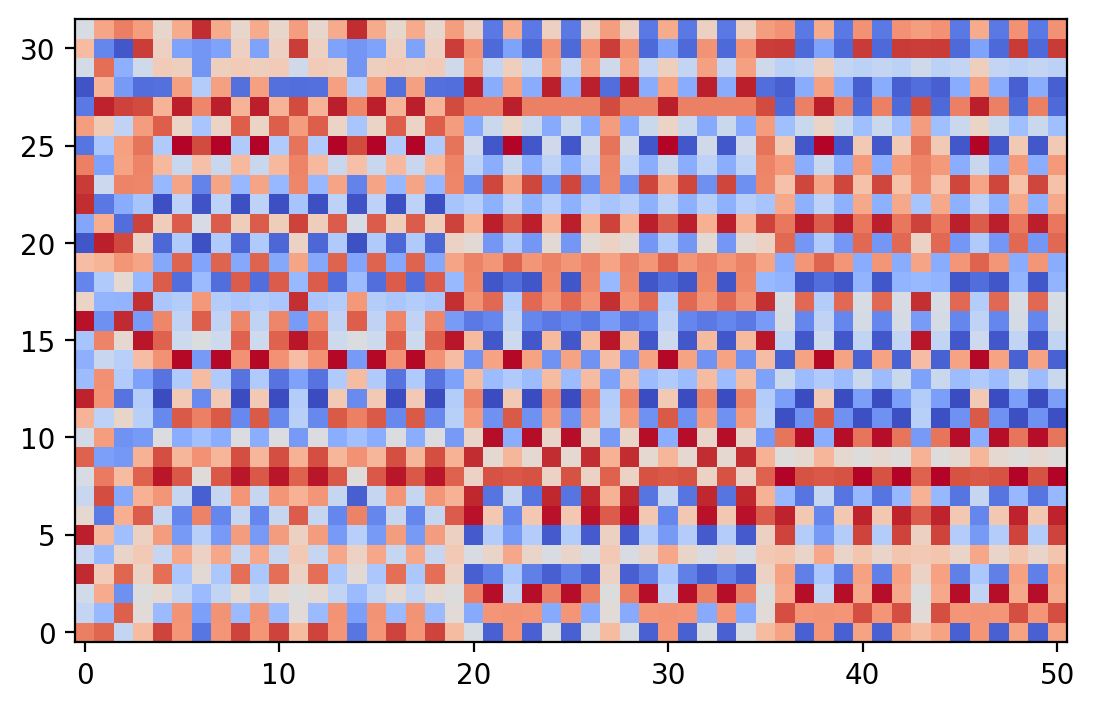

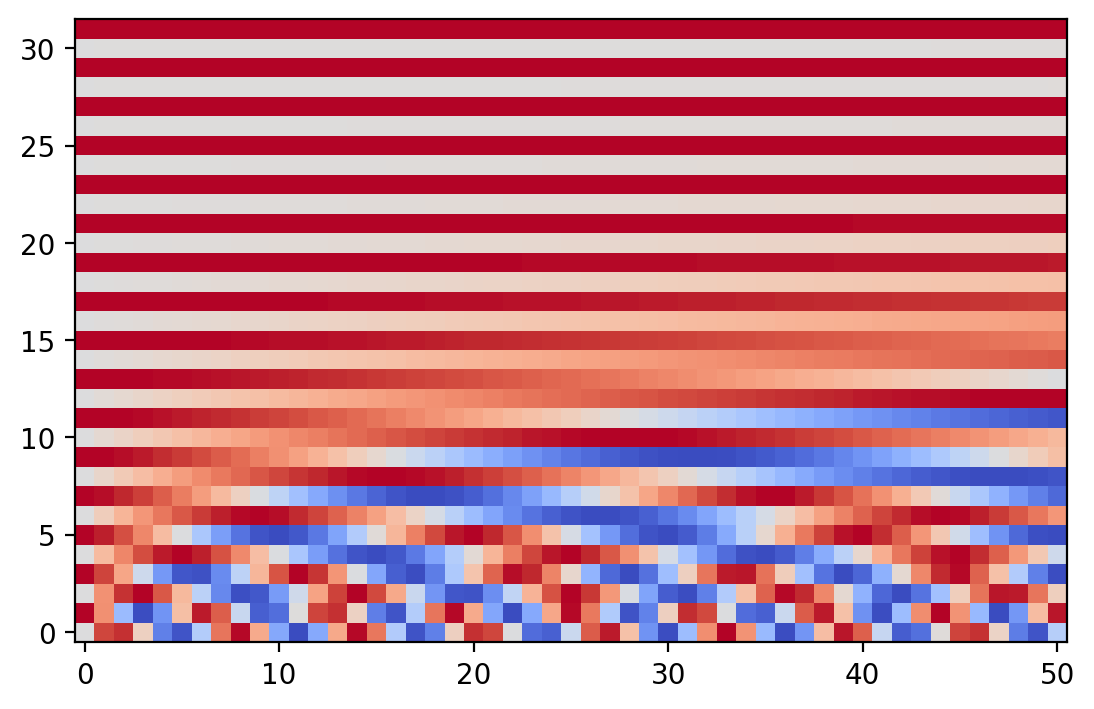

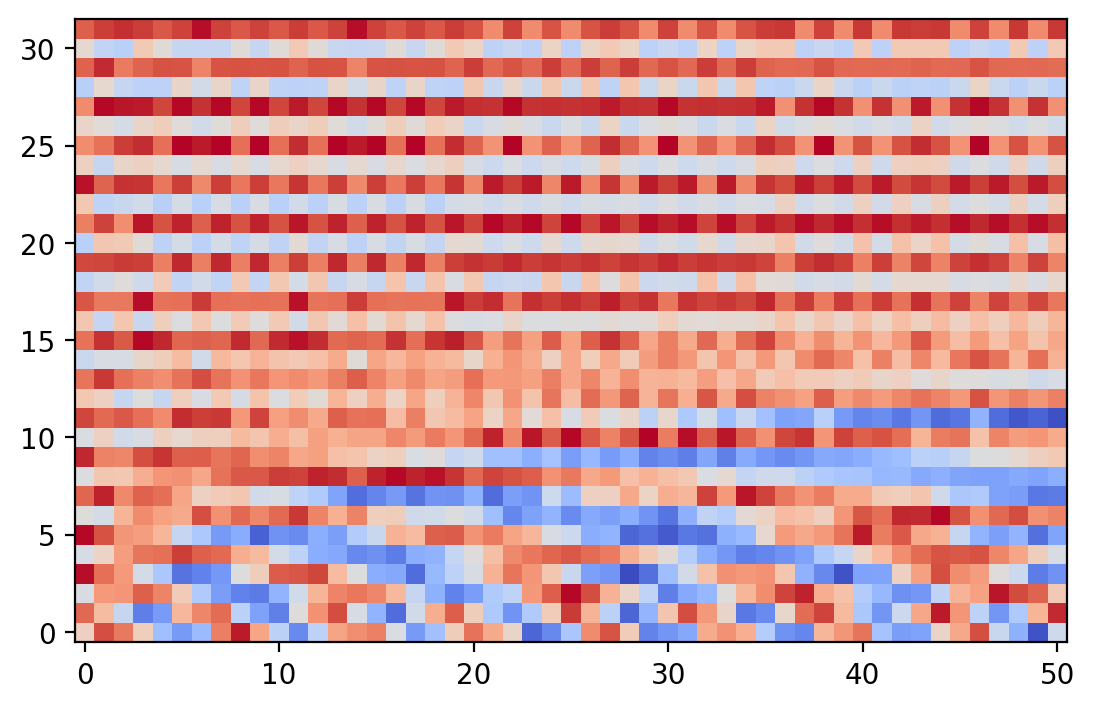

In [15]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(np.transpose(token_embedding), cmap="coolwarm", interpolation="nearest", origin="lower")
plt.show()
plt.imshow(np.transpose(position_embedding), cmap="coolwarm", interpolation="nearest", origin="lower")
plt.show()
plt.imshow(np.transpose(embedding), cmap="coolwarm", interpolation="nearest", origin="lower")
plt.show()

## 8. Build the Transformer model <a name="transformer_decoder"></a>

In [215]:
note_inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = keras.layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(notes_vocab_size, EMBEDDING_DIM // 2)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(durations_vocab_size, EMBEDDING_DIM // 2)(durations_inputs)
embeddings = keras.layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention")(embeddings)
note_outputs = keras.layers.Dense(notes_vocab_size, activation="softmax", name="note_outputs")(x)
duration_outputs = keras.layers.Dense(durations_vocab_size, activation="softmax", name="duration_outputs")(x)
model = keras.Model(
    inputs=[note_inputs, durations_inputs], outputs=[note_outputs, duration_outputs]  # attention_scores
)
model.compile("adam", loss=[keras.losses.SparseCategoricalCrossentropy(), keras.losses.SparseCategoricalCrossentropy()])
att_model = keras.Model(inputs=[note_inputs, durations_inputs], outputs=attention_scores)

In [216]:
model.summary()

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 token_and_position_embedding_3  (None, None, 128)   7552        ['input_3[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 token_and_position_embedding_4  (None, None, 128)   3072        ['input_4[0][0]']         

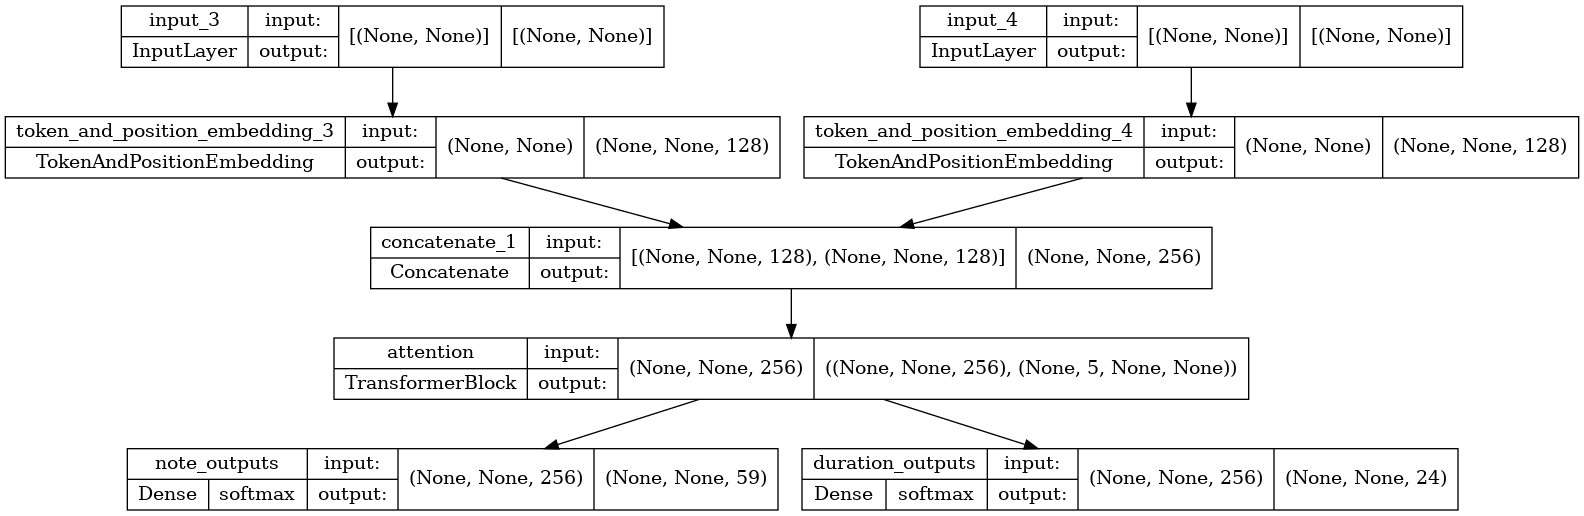

In [217]:
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [218]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")
    # model = keras.models.load_model('./models/model', compile=True)

## 9. Train the Transformer <a name="train"></a>

In [219]:
# Create a MusicGenerator checkpoint
class MusicGenerator(keras.callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {note: index for index, note in enumerate(index_to_note)}
        self.index_to_duration = index_to_duration
        self.duration_to_index = {duration: index for index, duration in enumerate(index_to_duration)}

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(notes[0][-1], temperature)
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(durations[0][-1], temperature)
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration)

        return new_note, sample_note_idx, sample_note, note_probs, sample_duration_idx, sample_duration, duration_probs

    def generate(self, start_notes, start_durations, max_tokens, temperature):

        attention_model = keras.Model(inputs=self.model.input, outputs=self.model.get_layer("attention").output)

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [self.duration_to_index.get(x, 1) for x in start_durations]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = music21.stream.Stream()

        midi_stream.append(music21.clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:

                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, music21.chord.Chord)
                    or isinstance(new_note, music21.note.Note)
                    or isinstance(new_note, music21.note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5)
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        midi_stream.show()
        midi_stream.write(
            "midi", fp=os.path.join("/app/notebooks/music/bach-cello/output", "output-" + str(epoch).zfill(4) + ".mid")
        )

In [220]:
# Create a model save checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [221]:
model.fit(
    ds,
    epochs=EPOCHS,
    # initial_epoch = 150,
    callbacks=[model_checkpoint_callback, tensorboard_callback, music_generator],
)

Epoch 1/5000
  1/108 [..............................] - ETA: 15:15 - loss: 2.8835 - note_outputs_loss: 2.6510 - duration_outputs_loss: 0.2325

KeyboardInterrupt: 

In [ ]:
# Save the final model
model.save("./models/model")

# 3. Generate music using the Transformer

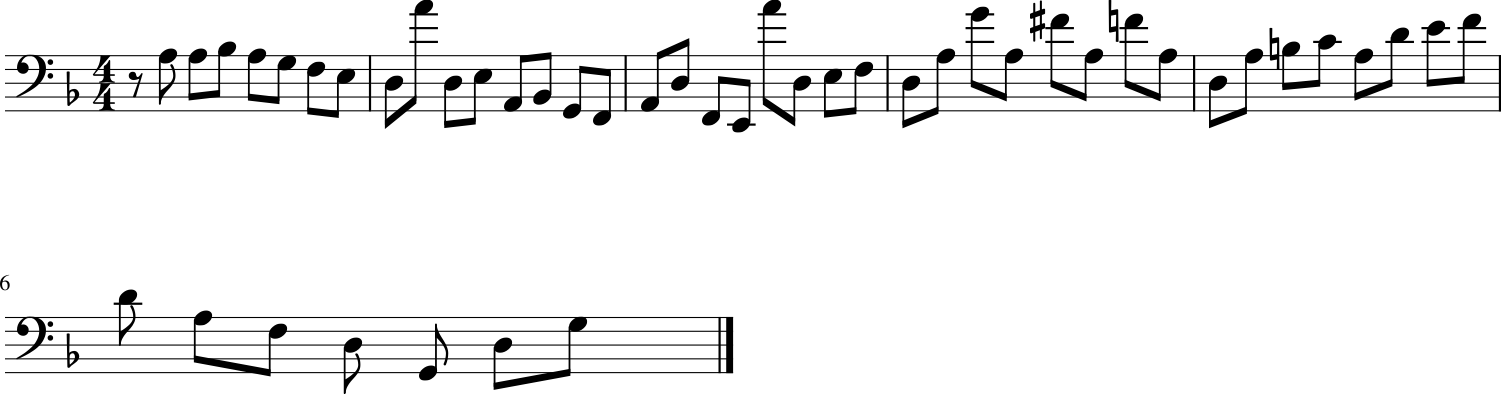

In [255]:
info = music_generator.generate(["START"], ["0.0"], max_tokens=50, temperature=0.5)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

## Write music to MIDI file

In [256]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write("midi", fp=os.path.join("/app/notebooks/music/bach-cello/output", "output-" + timestr + ".mid"))

'/app/notebooks/music/bach-cello/output/output-20221105-053338.mid'

## Note probabilities

In [257]:
max_pitch = 70
seq_len = len(info)
grid = np.zeros((max_pitch, seq_len), dtype=np.float32)

for j in range(seq_len):
    for i, prob in enumerate(info[j]["note_probs"]):
        try:
            pitch = music21.note.Note(notes_vocab[i]).pitch.midi
            grid[pitch, j] = prob
        except:
            pass  # Don't show key / time signatures

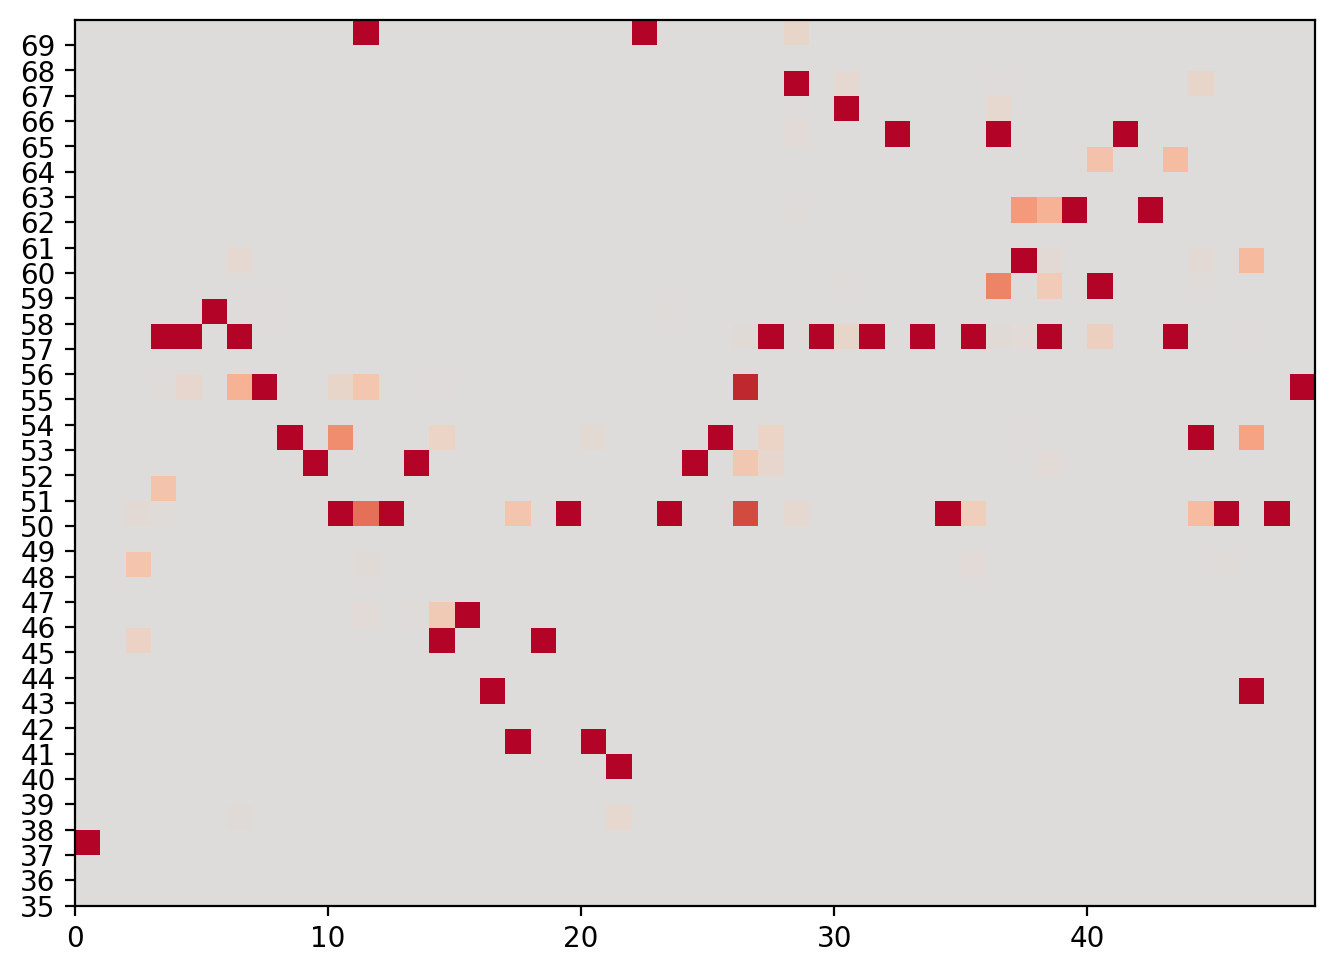

In [258]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_yticks([int(j) for j in range(35, 70)])
plt.imshow(grid[35:70, :], origin="lower", cmap="coolwarm", vmin=-0.5, vmax=0.5, extent=[0, seq_len, 35, 70])
plt.show()

## Attention Plot

In [259]:
plot_size = 20

att_matrix = np.zeros((plot_size, plot_size))
prediction_output = []
last_prompt = []

In [260]:
for j in range(plot_size):
    atts = info[j]["atts"].max(axis=0)
    att_matrix[: (j + 1), j] = atts
    prediction_output.append(info[j]["chosen_note"][0])
    last_prompt.append(info[j]["prompt"][0][-1])

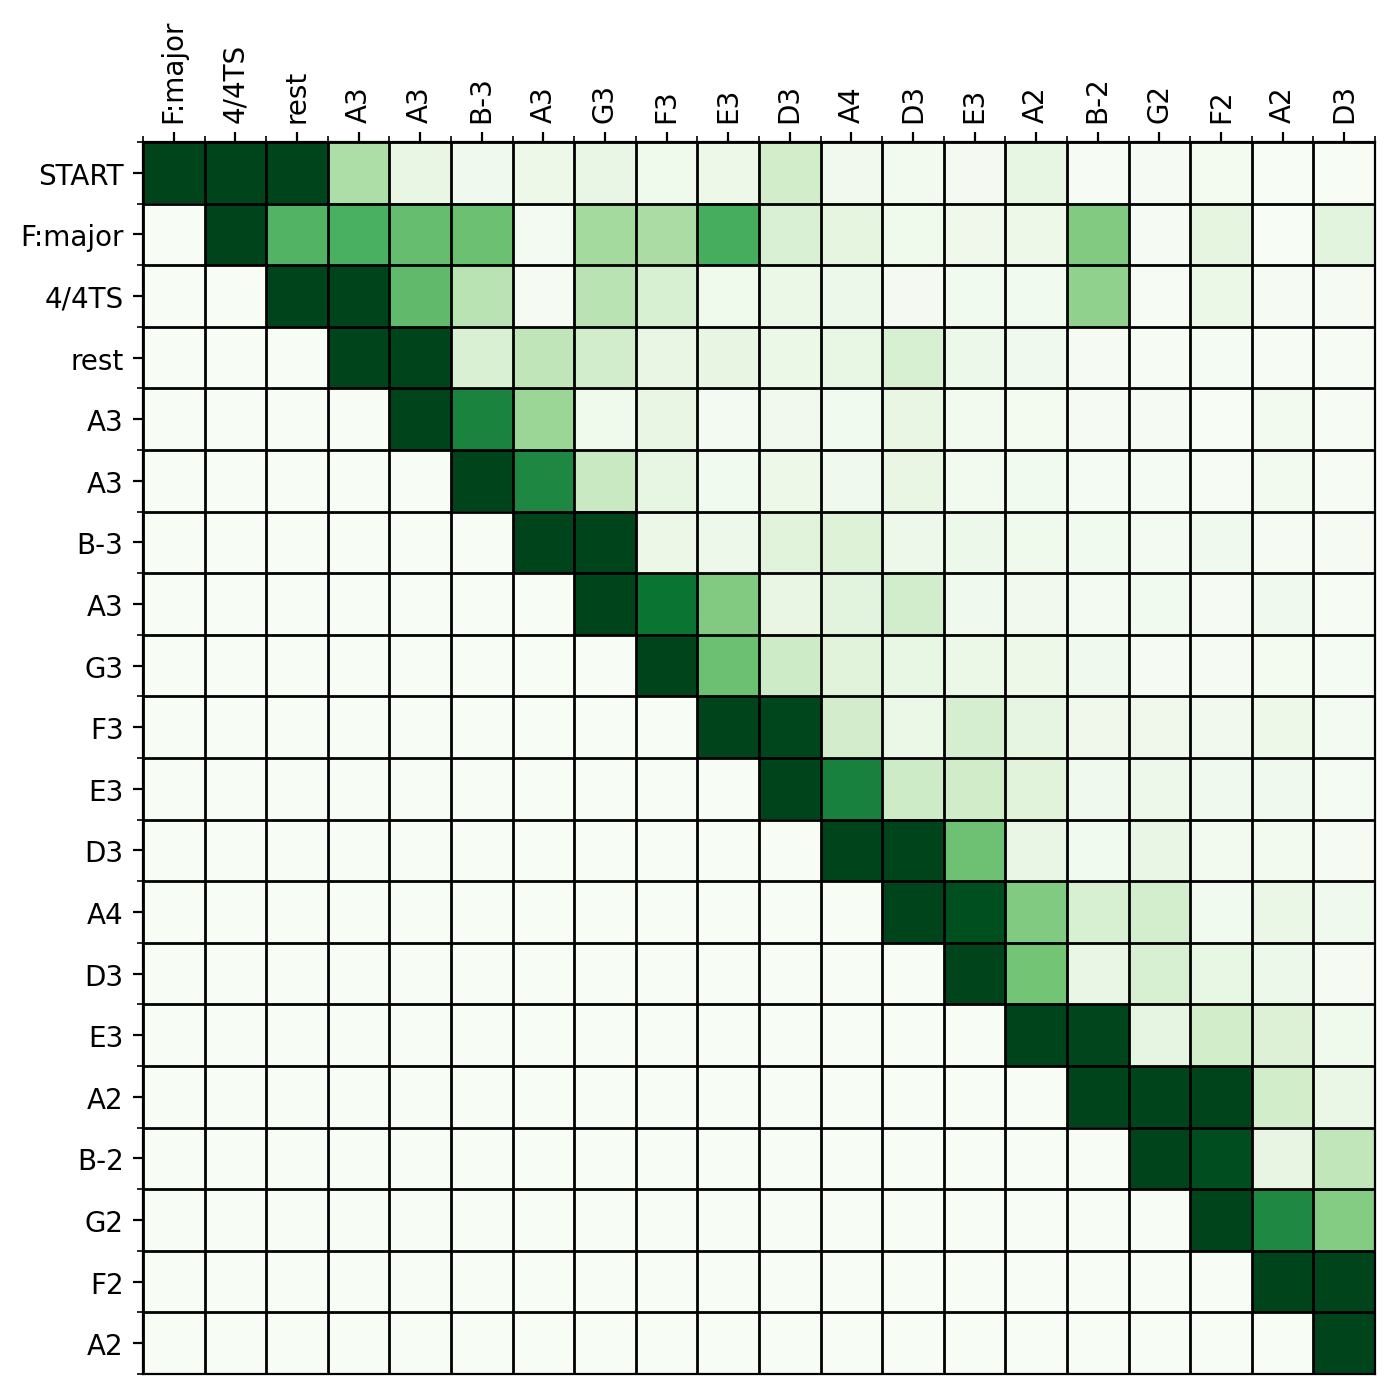

In [270]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(att_matrix, cmap="Greens", interpolation="nearest")

ax.set_xticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.set_yticks(np.arange(-0.5, plot_size, 1), minor=True)
ax.grid(which="minor", color="black", linestyle="-", linewidth=1)
ax.set_xticks(np.arange(plot_size))
ax.set_yticks(np.arange(plot_size))
ax.set_xticklabels(prediction_output[:plot_size])
ax.set_yticklabels(last_prompt[:plot_size])
ax.xaxis.tick_top()

plt.setp(ax.get_xticklabels(), rotation=90, ha="left", va="center", rotation_mode="anchor")
plt.show()

In [266]:
from matplotlib.font_manager import findfont, FontProperties

font = findfont(FontProperties(family=["sans-serif"]))
font

'/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'